balance contains non-positive values, applying log transformation with shift.
duration contains non-positive values, applying log transformation with shift.
campaign contains non-positive values, applying log transformation with shift.
pdays contains non-positive values, applying log transformation with shift.
previous contains non-positive values, applying log transformation with shift.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


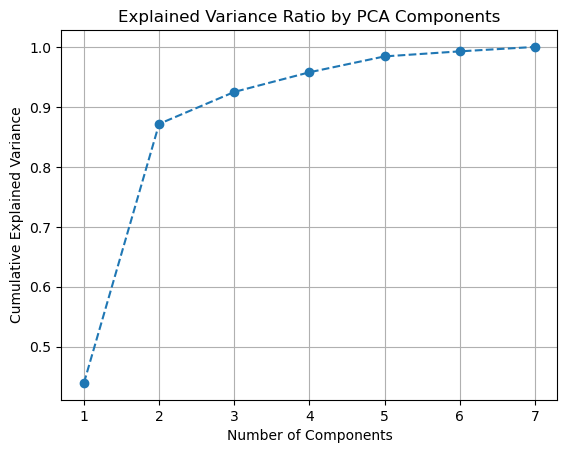

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


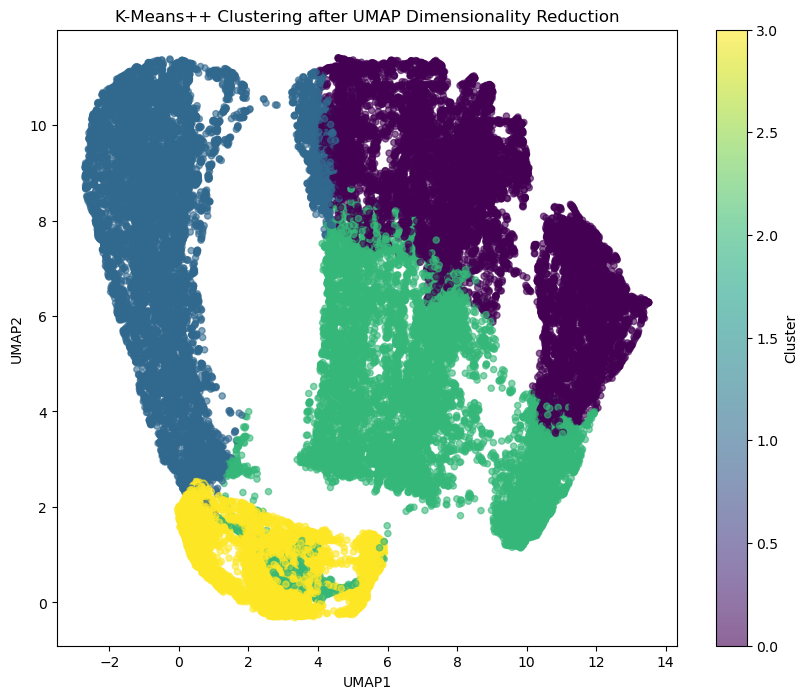

Cluster Summary (Numerical Features):
                 y       age   balance  day_of_week  duration  campaign  \
Cluster                                                                  
0        0.099561 -0.687631  1.604634     0.691718  1.072719  0.941936   
1        0.089918 -0.118617  1.603328    -1.136794  1.058248  0.854489   
2        0.085940  1.017717  1.627981     0.433324  1.041519  0.941804   
3        0.229543 -0.008695  1.625075    -0.186860  1.065078  0.831831   

            pdays  previous  
Cluster                      
0        0.693639  0.694047  
1        0.693726  0.694661  
2        0.694315  0.694445  
3        1.422747  1.160051  
Cluster Mode (Categorical Features):
                  job  marital  education default housing loan   contact month
Cluster                                                                      
0         management  married  secondary      no     yes   no  cellular   may
1        blue-collar  married  secondary      no     yes   no  c

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from ucimlrepo import fetch_ucirepo

# 1. 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 将目标变量 y 合并到 X 中，确保可以进行目标编码
X['y'] = y

# 将 'y' 转换为数值型：'yes' -> 1, 'no' -> 0
X['y'] = X['y'].map({'yes': 1, 'no': 0})

# 2. 识别数值特征和类别特征
numerical_cols = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

# 3. 对数值特征进行标准化
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 4. 处理右偏连续变量（对数转换）
right_skewed_cols = ['balance', 'duration', 'campaign', 'pdays', 'previous']
for col in right_skewed_cols:
    if (X[col] <= 0).any():
        print(f"{col} contains non-positive values, applying log transformation with shift.")
        X[col] = np.log1p(X[col] - X[col].min() + 1)  # 移位确保正值
    else:
        X[col] = np.log1p(X[col])  # log(x+1)避免零值问题

# 5. 目标编码：对月份特征进行目标编码（按订阅率计算均值）
month_target_encoding = X.groupby('month')['y'].mean()  # 按月计算订阅率的均值
X['month_encoded'] = X['month'].map(month_target_encoding)  # 将编码值映射到数据中

# 6. 目标编码：对job特征进行目标编码（按订阅率计算均值）
job_target_encoding = X.groupby('job')['y'].mean()  # 按job计算订阅率的均值
X['job_encoded'] = X['job'].map(job_target_encoding)  # 将编码值映射到数据中

# 7. 处理其他类别特征：对其他类别特征进行One-Hot编码
X_processed = pd.get_dummies(X[categorical_cols], drop_first=True)  # One-Hot编码
X_processed[numerical_cols] = X[numerical_cols]  # 将数值特征合并进来

# 8. 使用随机森林进行特征选择
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_processed, y)

# 查看特征重要性
importances = rf.feature_importances_

# 选择重要特征（基于特征重要性）
selector = SelectFromModel(rf, threshold="mean", max_features=10)
X_selected = selector.transform(X_processed)

# 9. 降维：使用PCA来选择最适合的降维维度
pca = PCA().fit(X_selected)  # 对数据进行PCA拟合
explained_variance = pca.explained_variance_ratio_

# 绘制方差解释比的累积图
plt.plot(range(1, len(explained_variance)+1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Explained Variance Ratio by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# 根据方差解释比选择降维维度（如降到 3 维）
umap_model = umap.UMAP(n_components=3, random_state=42)  # 降到3维
X_umap = umap_model.fit_transform(X_selected)

# 10. 聚类：使用K-Means++聚类
kmeans_plus = KMeans(n_clusters=4, init='k-means++', random_state=42)  # 设置4个簇
clusters_kmeans = kmeans_plus.fit_predict(X_umap)  # 使用降维后的数据进行聚类

# 11. 可视化聚类结果（降维后的数据）
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_kmeans, cmap='viridis', s=20, alpha=0.6)
plt.title('K-Means++ Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

# 12. 聚类分析：查看每个簇的订阅率（y）和特征均值
X_raw = X.copy()
X_raw['Cluster'] = clusters_kmeans

# 聚类统计信息（数值特征均值）
cluster_summary = X_raw.groupby('Cluster').agg({
    'y': 'mean',  # 计算每个簇的订阅率均值
    **{col: 'mean' for col in numerical_cols}  # 计算每个簇的数值型特征均值
})
print("Cluster Summary (Numerical Features):\n", cluster_summary)

# 聚类统计信息（类别特征的众数）
cluster_mode = X_raw.groupby('Cluster').agg({
    **{col: lambda x: x.mode()[0] for col in categorical_cols}  # 计算每个簇的类别特征的众数
})
print("Cluster Mode (Categorical Features):\n", cluster_mode)

# 13. 评估聚类效果：计算轮廓系数（Silhouette Score）
silhouette_avg = silhouette_score(X_umap, clusters_kmeans)
print(f"Silhouette Score for K-Means++: {silhouette_avg:.4f}")

# 14. 评估聚类效果：计算 Davies-Bouldin指数
db_score = davies_bouldin_score(X_umap, clusters_kmeans)
print(f"Davies-Bouldin Score for K-Means++: {db_score:.4f}")

# 15. 评估聚类效果：计算 Calinski-Harabasz指数
ch_score = calinski_harabasz_score(X_umap, clusters_kmeans)
print(f"Calinski-Harabasz Score for K-Means++: {ch_score:.4f}")

# 16. 保存最终聚类结果
X_raw.to_csv('umap_kmeans_plus_clustered_data.csv', index=False)


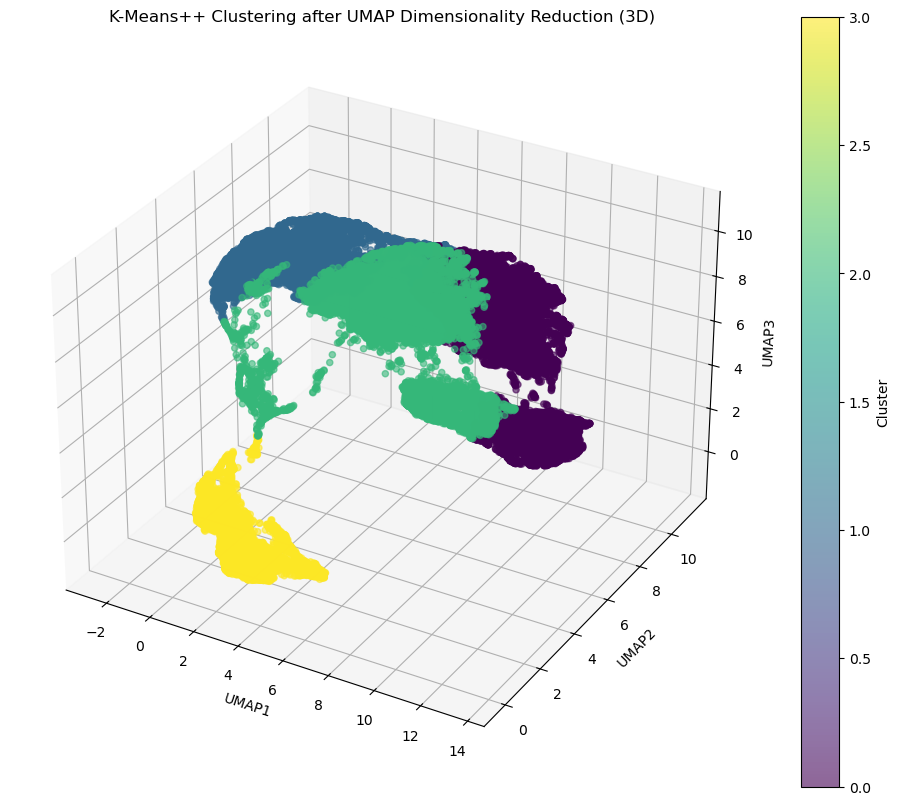

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# 可视化 K-Means++ 聚类结果（3D）
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=clusters_kmeans, cmap='viridis', s=20, alpha=0.6)

# 设置图标题和标签
ax.set_title('K-Means++ Clustering after UMAP Dimensionality Reduction (3D)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# 添加颜色条
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()


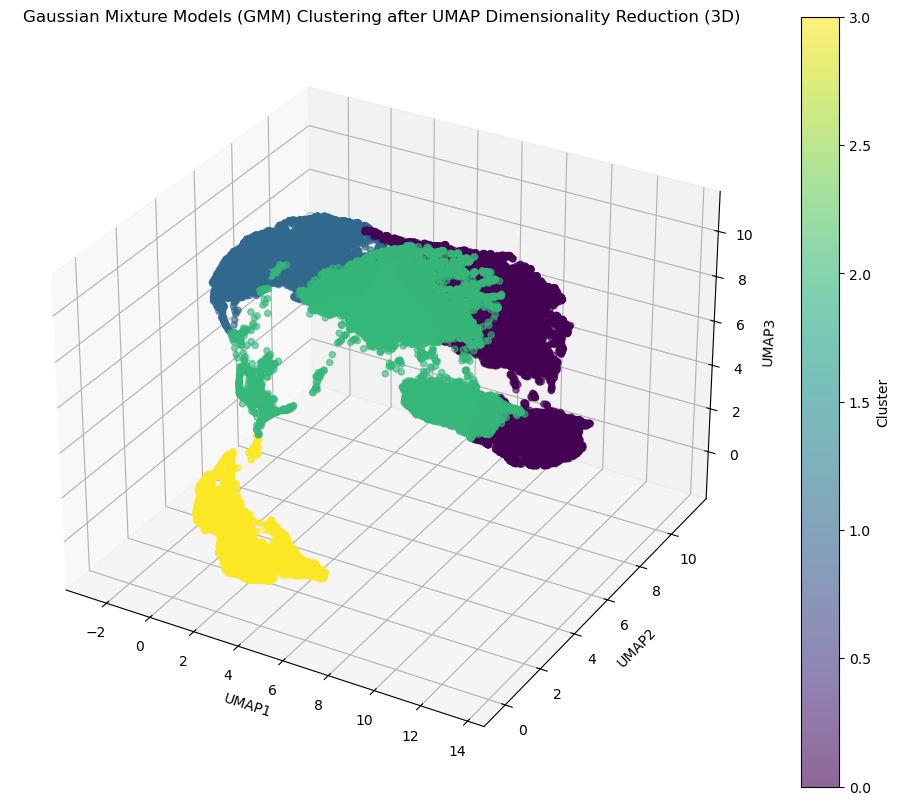

Silhouette Score for GMM: 0.4520
Davies-Bouldin Score for GMM: 0.8829
Calinski-Harabasz Score for GMM: 41113.8320


In [9]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 高斯混合模型（GMM）聚类
gmm = GaussianMixture(n_components=4, random_state=42)
clusters_gmm = gmm.fit_predict(X_umap)

# 可视化 GMM 聚类结果（3D）
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=clusters_gmm, cmap='viridis', s=20, alpha=0.6)

# 设置图标题和标签
ax.set_title('Gaussian Mixture Models (GMM) Clustering after UMAP Dimensionality Reduction (3D)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# 添加颜色条
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

# 评估 GMM 聚类效果
silhouette_avg = silhouette_score(X_umap, clusters_gmm)
print(f"Silhouette Score for GMM: {silhouette_avg:.4f}")

# 计算 Davies-Bouldin指数
db_score = davies_bouldin_score(X_umap, clusters_gmm)
print(f"Davies-Bouldin Score for GMM: {db_score:.4f}")

# 计算 Calinski-Harabasz指数
ch_score = calinski_harabasz_score(X_umap, clusters_gmm)
print(f"Calinski-Harabasz Score for GMM: {ch_score:.4f}")


In [7]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# 假设你已经有 X_umap 或者其他降维数据
# 使用谱聚类进行聚类
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
clusters_spectral = spectral.fit_predict(X_umap)

# 可视化谱聚类结果（降维后的数据）
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_spectral, cmap='viridis', s=20, alpha=0.6)
plt.title('Spectral Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

# 评估谱聚类效果
silhouette_avg = silhouette_score(X_umap, clusters_spectral)
print(f"Silhouette Score for Spectral Clustering: {silhouette_avg:.4f}")

db_score = davies_bouldin_score(X_umap, clusters_spectral)
print(f"Davies-Bouldin Score for Spectral Clustering: {db_score:.4f}")

ch_score = calinski_harabasz_score(X_umap, clusters_spectral)
print(f"Calinski-Harabasz Score for Spectral Clustering: {ch_score:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

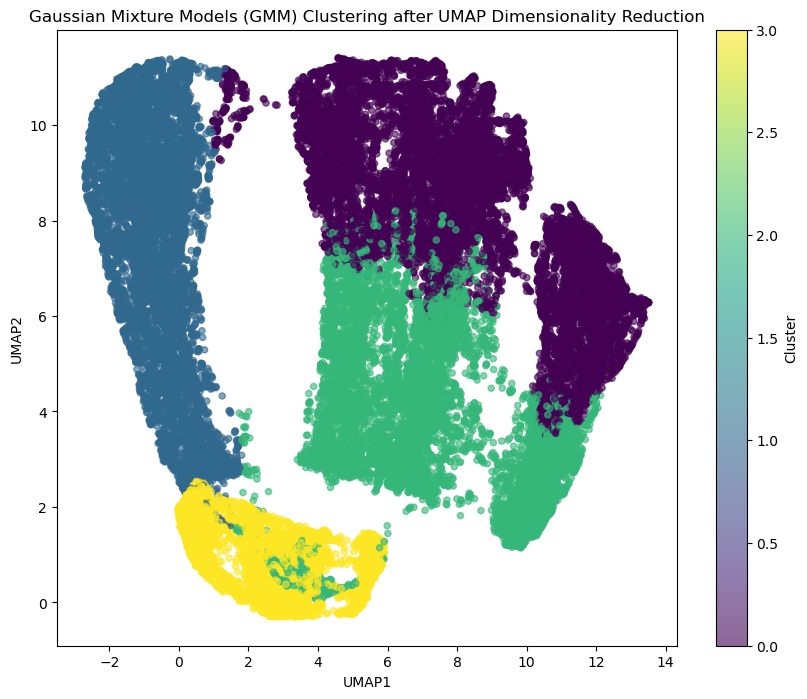

Silhouette Score for GMM: 0.4520


In [3]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# 高斯混合模型（GMM）聚类
gmm = GaussianMixture(n_components=4, random_state=42)
clusters_gmm = gmm.fit_predict(X_umap)

# 可视化 GMM 聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_gmm, cmap='viridis', s=20, alpha=0.6)
plt.title('Gaussian Mixture Models (GMM) Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

# 评估 GMM 聚类效果
silhouette_avg = silhouette_score(X_umap, clusters_gmm)
print(f"Silhouette Score for GMM: {silhouette_avg:.4f}")


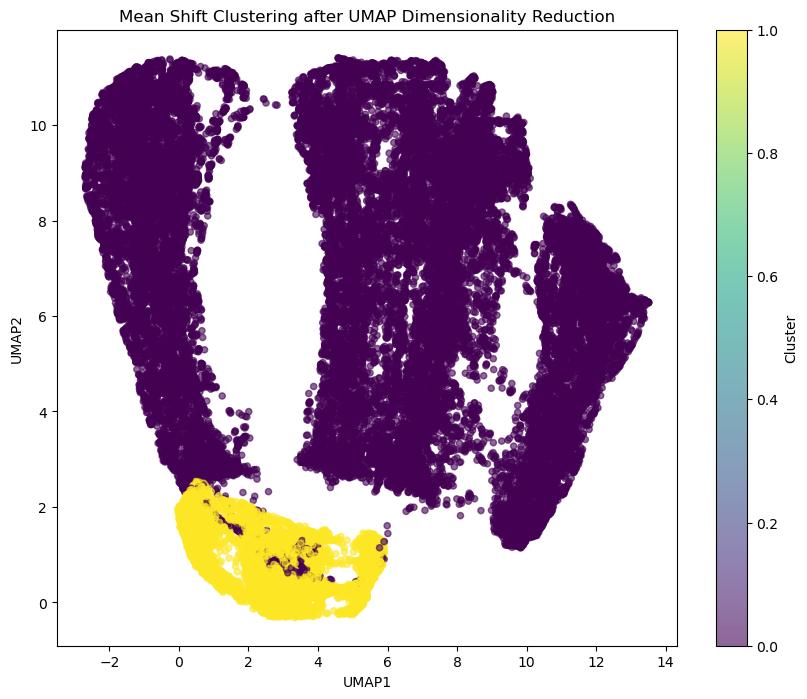

Silhouette Score for Mean Shift: 0.4083


In [4]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Mean Shift 聚类
meanshift = MeanShift()
clusters_meanshift = meanshift.fit_predict(X_umap)

# 可视化 Mean Shift 聚类结果
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_meanshift, cmap='viridis', s=20, alpha=0.6)
plt.title('Mean Shift Clustering after UMAP Dimensionality Reduction')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

# 评估 Mean Shift 聚类效果
silhouette_avg = silhouette_score(X_umap, clusters_meanshift)
print(f"Silhouette Score for Mean Shift: {silhouette_avg:.4f}")


In [5]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# 计算 Davies-Bouldin Index
db_score = davies_bouldin_score(X_umap, clusters_meanshift)
print(f"Davies-Bouldin Score for Mean Shift: {db_score:.4f}")

# 计算 Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_umap, clusters_meanshift)
print(f"Calinski-Harabasz Score for Mean Shift: {ch_score:.4f}")


Davies-Bouldin Score for Mean Shift: 0.8254
Calinski-Harabasz Score for Mean Shift: 21192.3142
